# /image/*.png と /Label/*.png を使って衣服検出


## 1. import

In [61]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

## 2. Configuration(訓練の為の設定)

In [62]:
class ClothConfig(Config):

    
    def __init__(self):
        """Set values of computed attributes."""
        # Effective batch size
        self.BATCH_SIZE = self.IMAGES_PER_GPU * self.GPU_COUNT

        # Input image size
        #self.IMAGE_SHAPE = np.array(
        #    [self.IMAGE_MIN_DIM, self.IMAGE_MAX_DIM, 3]) #changed 02/27
        self.IMAGE_SHAPE = np.array(
            [self.IMAGE_MAX_DIM, self.IMAGE_MAX_DIM, 3])
        
        
        # Compute backbone size from input image size
        self.BACKBONE_SHAPES = np.array(
            [[int(math.ceil(self.IMAGE_SHAPE[0] / stride)),
              int(math.ceil(self.IMAGE_SHAPE[1] / stride))]
             for stride in self.BACKBONE_STRIDES])
    
    
    # Give the configuration a recognizable name
    NAME = "clothes"

    # Train on 1 GPU and 8 images per GPU. We can put multiple images on each
    # GPU because the images are small. Batch size is 8 (GPUs * images/GPU).
    GPU_COUNT = 1
    IMAGES_PER_GPU = 8

    # Number of classes (including background)
    NUM_CLASSES = 1 + 3  # background + 3 shapes

    # Use small images for faster training. Set the limits of the small side
    # the large side, and that determines the image shape.
    IMAGE_MIN_DIM = 256#320
    IMAGE_MAX_DIM = 256

    # Use smaller anchors because our image and objects are small
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)  # anchor side in pixels

    # Reduce training ROIs per image because the images are small and have
    # few objects. Aim to allow ROI sampling to pick 33% positive ROIs.
    TRAIN_ROIS_PER_IMAGE = 32

    # Use a small epoch since the data is simple
    STEPS_PER_EPOCH = 100

    # use small validation steps since the epoch is small
    VALIDATION_STEPS = 5
    
config = ClothConfig()
config.display()


Configurations:
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     8
BBOX_STD_DEV                   [ 0.1  0.1  0.2  0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 8
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  256
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [ 123.7  116.8  103.9]
MINI_MASK_SHAPE                (56, 56)
NAME                           clothes
NUM_CLASSES                    4
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NMS_ROIS_TRAINING         2

# 3. モデル生成と訓練済みの重みをLoad

In [63]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)


# 重みをload

# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

## 4. データセットの設定

画像/ラベルデータの例.


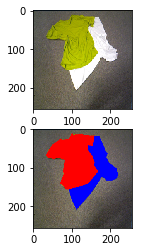

Error. No such file or directory: ./image/1_ex1.png
Error. No such file or directory: ./Label/1_ex1_label.png
Error. No such file or directory: ./image/13_ex1.png
Error. No such file or directory: ./Label/13_ex1_label.png
Error. No such file or directory: ./image/24_ex1.png
Error. No such file or directory: ./Label/24_ex1_label.png
(データ数, H, W, RGBの3) =  (100, 256, 256, 3)


In [64]:
#画像データはarray型にする。
import cv2

#pngデータ読込
image_num = 100
images = []
labels = []

size_tmp = 256, 256

print("画像/ラベルデータの例.")
img = cv2.imread("./train/0_ex1.png")
img = cv2.resize(img, size_tmp)
label = cv2.imread("./Label/0_ex1_label.png")
label = cv2.resize(label, size_tmp)
plt.subplot(211)
plt.imshow(img[:,:,::-1])

#上のconfigの都合上とりあえずリサイズする。そのため

plt.subplot(212)
plt.imshow(label[:,:,::-1])
plt.show()

for i in range(image_num):
    try:
        #画像読込
        img_name = "./image/" + str(i) + "_ex1.png"
        img = cv2.imread(img_name)
        img = cv2.resize(img,(256,256))
        images.append(img)
        #ラベル画像読込
        label_name = "./Label/" + str(i) + "_ex1_label.png"
        label = cv2.imread(label_name)
        label = cv2.resize(label, (256,256))
        labels.append(label)
        
    except:
        print("Error. No such file or directory: " + img_name)
        print("Error. No such file or directory: " + label_name)



dataset_train = np.array(images)
print("(データ数, H, W, RGBの3) = ", dataset_train.shape)

### Notebook Preferences

In [65]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### 4.5 データセットの型を整える

In [101]:
num_train = 90
num_test = 9

class ClothesDataset(utils.Dataset):
    
    
    def load_clothes(self, count, width, height, flag):
        #classを追加
        
        import json
        from statistics import mean, median,variance,stdev
        
        self.add_class("clothes",1,"tg")
        self.add_class("clothes",2,"tw")
        bg_color = [255, 255, 255]
        
        print(count)
        
        for i in range(count): #衣服画像の枚数だけ繰り返す
            shapes = []
            if(flag == 1):
                ID = i + num_train #連番の最後の方をテスト用にしているので 0301 pancho
            else: ID = i
            
            if(flag == 0):
                json_name = "./train/" + str(ID) + "_ex1.json"
            else: json_name = "./test/" + str(ID) + "_ex1.json"
            
            f = open(json_name)
            data = json.load(f)
            json_label_num = len(data["shapes"]) #num pf shapes on each image

            for j in range(json_label_num):
                
                label = data["shapes"][j]["label"]
                points = np.array(data["shapes"][j]["points"]) #once convert to array to calculate
                x_center = int(mean(points[:,0]))
                y_center = int(mean(points[:,1]))
                #size will be the begger one by compareing x_width with y_width
                x_width = max(points[:,0]) - min(points[:,0])
                y_width = max(points[:,1]) - min(points[:,1])
                if(x_width > y_width):
                    size = int(x_width+10) 
                else: size = int(y_width+10)
    
                if(label =="tg"):#green Tshirts
                    color = (255,0,0) # RED for tg
                elif(label == "tw"): 
                    color = (0,0,255) #BLUE for tw
    
                else: print("ERROR. the object has no class id like \"tg\"")
    
                #set defined Data for "self.add_image"
                data_to_shapes = (label, color, (x_center, y_center, size))
                shapes.append(data_to_shapes)
                
            print(i, "th \"shapes\". ", shapes)
            print(i ,"th bg_color. ", bg_color)
            print("\n")
            path = "./image/" + str(i) + "_ex1.png"     
            self.add_image("clothes", image_id = ID, path = path,
                           width = width, height = height,
                        bg_color = bg_color, clothes = shapes)
                
                
        
        
            
    def load_image (self, image_id):
        info = self.image_info[image_id]
        bg_color = np.array(info['bg_color']).reshape([1, 1, 3])
        img_name = "./image/" + str(image_id) + "_ex1.png"
        image = cv2.imread(img_name)
        image = image * bg_color.astype(np.uint8)
        return image
        
            
    def image_reference(self, image_id):
        info = self.image_info[image_id] 
        if info["source"] == "clothes":
            return info["clothes"]
        else:
            super(self.__class__).image_reference(self, image_id)

            
    
    def load_mask(self, image_id):
        info = self.image_info[image_id]
        shapes = info['clothes']
        count = len(shapes)
        mask_name = "./Label/" + str(image_id) + "_ex1_label.png"
        #mask =cv2.imread(mask_name)
        #mask = np.array(mask)
        mask = np.zeros([info['height'], info['width'], count], dtype=np.uint8)
        occlusion = np.logical_not(mask[:, :, -1]).astype(np.uint8)
        for i in range(count-2, -1, -1):
            mask[:, :, i] = mask[:, :, i] * occlusion
            occlusion = np.logical_and(occlusion, np.logical_not(mask[:, :, i]))
        # Map class names to class IDs.
        print("enter_mask _R-CNN")
        class_ids = np.array([self.class_names.index(s[0]) for s in shapes])
        #class_ids = np.empty([0], np.int32)
        
        
        """
        mask 
        
        
        class_ids . リスト型でアイテムのidを格納. 
        ex. class_ids = [1,2] .image_idで指定した画像に "tg" と "tw" が1つずつ格納
        """
        
        return mask, class_ids.astype(np.int32)

In [102]:
#Training dataset
train_num = 89
test_num = 11

flag = {"train": 0,"test":1}

dataset_train = ClothesDataset()
dataset_train.load_clothes(90, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], flag["train"])
dataset_train.prepare()

# Validation dataset
dataset_val = ClothesDataset()
dataset_val.load_clothes(10, config.IMAGE_SHAPE[0], config.IMAGE_SHAPE[1], flag["test"])
dataset_val.prepare()

90
0 th "shapes".  [('tg', (255, 0, 0), (133, 56, 170)), ('tw', (0, 0, 255), (212, 86, 160))]
0 th bg_color.  [255, 255, 255]


1 th "shapes".  [('tg', (255, 0, 0), (133, 56, 170)), ('tw', (0, 0, 255), (212, 86, 160))]
1 th bg_color.  [255, 255, 255]


2 th "shapes".  [('tg', (255, 0, 0), (143, 100, 175)), ('tw', (0, 0, 255), (276, 101, 157)), ('tw', (0, 0, 255), (188, 169, 57))]
2 th bg_color.  [255, 255, 255]


3 th "shapes".  [('tg', (255, 0, 0), (152, 105, 177)), ('tw', (0, 0, 255), (276, 99, 158)), ('tw', (0, 0, 255), (188, 170, 58))]
3 th bg_color.  [255, 255, 255]


4 th "shapes".  [('tw', (0, 0, 255), (113, 71, 190)), ('tg', (255, 0, 0), (181, 48, 166))]
4 th bg_color.  [255, 255, 255]


5 th "shapes".  [('tw', (0, 0, 255), (113, 83, 191)), ('tg', (255, 0, 0), (192, 54, 165))]
5 th bg_color.  [255, 255, 255]


6 th "shapes".  [('tw', (0, 0, 255), (127, 120, 199)), ('tg', (255, 0, 0), (163, 61, 188))]
6 th bg_color.  [255, 255, 255]


7 th "shapes".  [('tw', (0, 0, 255), (108, 1

enter_mask _R-CNN


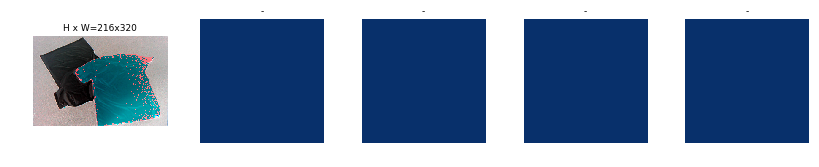

enter_mask _R-CNN


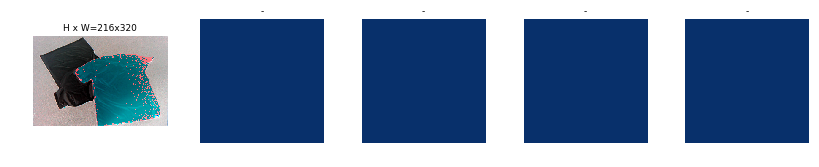

enter_mask _R-CNN


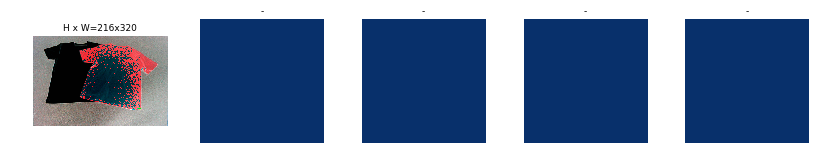

enter_mask _R-CNN


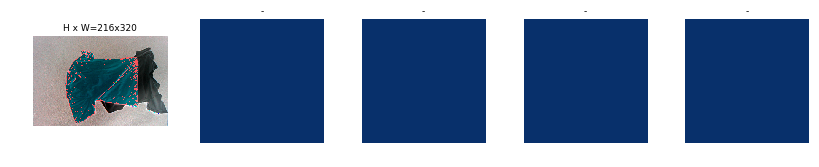

In [108]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

# 5. ラベル設定

In [104]:
#BG.back ground, tg. Tshirts Green, Tshirts White
class_name = ["BG", "tg", "tw"]


# 6. 訓練

In [107]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1,
           layers='heads')

/home/ubuntu/.pyenv/versions/anaconda3-5.0.1/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:600: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)
ERROR:root:Error processing image {'id': 92, 'source': 'clothes', 'path': './image/2_ex1.png', 'width': 256, 'height': 256, 'bg_color': [255, 255, 255], 'clothes': [('tw', (0, 0, 255), (205, 76, 198)), ('tg', (255, 0, 0), (121, 98, 183))]}
Traceback (most recent call last):
  File "/home/ubuntu/code_MaskR-CNN/model.py", line 1632, in data_generator
    use_mini_mask=config.USE_MINI_MASK)
  File "/home/ubuntu/code_MaskR-CNN/model.py", line 1220, in load_image_gt
    mask = utils.minimize_mask(bbox, mask, config.MINI_MASK_SHAPE)
  File "/home/ubuntu/code_MaskR-CNN/utils.py", line 462, in minimize_mask
    raise Exception("Invalid bounding box with area of zero")
Except


Starting at epoch 0. LR=0.001

Checkpoint Path: /home/ubuntu/code_MaskR-CNN/logs/clothes20180301T1810/mask_rcnn_clothes_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mr

Exception: Invalid bounding box with area of zero

In [1]:
# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

NameError: name 'model' is not defined

# 7. Object detection (テスト)

In [ ]:
#テスト用imageを取得

from numpy.random import *

flag = 0
while(flag == 0):
    testid = randint(100)
    
    if(testid != 1 and testid !=24):
        flag = 1

test_img_name = "./image/" + str(testid) + "_ex1.png"
test_img = plt.imread(test_img_name)


#detection
results = model.detect([test_img], verbose=1)

# Visualize Results

r = results[0]
visualize.display_instances(test_img, r['rois'], r['masks'], r['class_ids'], 
                           class_names, r["scores"])


# json から情報取得

In [145]:
#import 
import json
from statistics import mean, median,variance,stdev

shapes = []
json_name = "./image/0_ex1.json"
f = open(json_name)
data = json.load(f)
json_label_num = len(data["shapes"]) #num pf shapes on each image

for i in range(json_label_num):
    label = data["shapes"][i]["label"]
    print("label", i ,". ", label)
    points = np.array(data["shapes"][0]["points"]) #once convert to array to calculate
    x_mean = points[:,0]
    y_mean = points[:,1]
    #s はx_widthとy_widthの大きい方を用いて計算
    x_width = max(points[:,0]) - min(points[:,0])
    y_width = max(points[:,1]) - min(points[:,1])
    if(x_width > y_width):
        size = x_width + 10 #余裕をもたせる
    else: size = y_width + 10
    
    if(label =="tg"):#green Tshirts
        color = (255,0,0) # RED
    elif(label == "tw"): 
        color = (0,0,255) #white Tshirts
    
    else: print("ERROR. the object has no class id like \"tg\"")


label 0 .  tg
label 1 .  tw
